# PNEUMONIA CHEST X-RAY DATECTION

![Chest X-Ray Image](Readme_Images/chest_x-ray.jpg)
- **Pneumonia** is a severe lung infection that causes _tiny air sacs in the lungs to be inflamed and filled with fluid or pus_.

## Facts about Pneumonia

- It is the worlds leading cause of death among children under the age of 5 years.
- It is the most commomn reason for children to be hospitalized.
- In adults, it is prevalent cause of hospital admissions other than women giving birth.

## Pneumonia Detection

- Chest X-rays have been the best tool to detect any form of Pneumonia.
- **Radiologists** may have a hard time identifying whether something is _infiltrate_ on the X-Ray images.(_infiltrate_: a substance that is denser than air, eg. pus or fluid)
- The challenges in identifying the _infiltrate_ subtance in the lungs by radiologists may cause delay in diagnosis which may increase the disease severity and associated mortality rate.

## Project Goal

- This project aims at creating a model that fast detects Pneumonia in the Lungs of patients thus **early diagnosis** of Pneumonia and hence **early treatment**.
- The **early diagnosis and treatment** of Pneumonia will hence reduce death rates for children under the age of 5 years and adults above 65 years.

### Why CNN?

- Well, computers when well trained, will potentially have higher accuracy in detecting anomaly in the X-Ray images of individuals, thus being more efficient for early treatment of Pneumonia.

In [4]:
# Data Preprocessing
import pandas as pd # type: ignore
import numpy as np # type: ignore
# Data Visualisation
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
# ROC, AUC Curves
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tensorflow.keras.metrics import AUC # type: ignore
# keras
from tensorflow import keras # type: ignore
# Backend
from tensorflow.keras import backend as K# type: ignore
# Regularisation
from tensorflow.keras.regularizers import l2 # type: ignore
# CNN model
from tensorflow.keras.models import Sequential # type: ignore
# Layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation # type: ignore
# Image data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
# Optimizers
from tensorflow.keras.optimizers import Adam # type: ignore
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # type: ignore
# Tensorflow
import tensorflow as tf # type: ignore
# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve # type: ignore
# Math
import math
# OS
import os
# random
import random
# tensor processing unit
from tensorflow.core import tpu

import time
import glob
from collections import Counter
# Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preprocessing

1. Setting random seed values for training the model.
2. Create file paths to local folders containing X-ray images.
3. Set-up hyperparameters to be used in tuning the model.
4. Generate Image Data Batches(train, validation and test batches).

**i. Setting Random Seed Values**

In [ ]:
# Set a seed value
seed_value = 42

# 1. Set 'PYTHONHASHSEED' environment variable at a fixed value.
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set 'python' built-in pseudo-random generator at a fixed value.
random.seed(seed_value)

# 3. set 'numpy' pseudo-random generator at a fixed value.
np.random.seed(seed_value)

# 4. Set 'tensorflow' pseudo-random generator at a fixed value.
tf.random.set_seed(seed_value)

**Why fixed seed value at 42?**

- To ensure consistent hashing behavior of across all runs of our model from the _Python built-in_ hash function.
- To ensure that whenever _random_ module generates random numbers, they are produced in the same sequence given the same seed.
- To ensure consistent generation of random values produced by NumPy _random_ module.
- For the _TensorFlow_ Random seed value, it is set to a fixed value to ensure that the same random values are used for calculations across runs.

- **NB**: The seed value has been set to **42** due to it's popularity in use while creating models. A random integer can been used for a seed value of the model. By standard most engineers use a seed value of 42.

**Reproducability**

- We will hence have easier **debugging** since for errors occuring we can rerun the code with the same randomness thus ease in tracing of errors.
- **Comparison** of different models or configurations in our model will have a common starting point of randomness.
- **Sharing**: Sharing this code and seed values will allow easier verification of results by a different user of the model.

**ii. Loading the Images Into Image Data Generators**

In [ ]:
#  Set file paths to image files
parent_directory = "C:\\Users\\njugu\\Documents\\Datasets\\chest_xray"
train_path = parent_directory + "\\"+ 'train'
test_path = parent_directory + '\\' + 'test'
val_path = parent_directory + '\\' + 'val'

# Setting hyperparameters
hyper_dim = 224
hyper_batch_size = 128
hyper_epochs = 100
hyper_channels = 1 # GrayScale
hyper_mode = 'grayscale'

# Image Augmentation for train data
train_datagen = ImageDataGenerator(rescale = 1./255.0,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.0)
val_datagen = ImageDataGenerator(rescale = 1./255.0)

# Loading the Images
try:
    train_gen = train_datagen.flow_from_directory(directory = train_path,
                                            target_size = (hyper_dim, hyper_dim),
                                            batch_size = hyper_batch_size,
                                            color_mode = hyper_mode,
                                            class_mode = 'binary',
                                            seed = seed_value)

    test_gen = test_datagen.flow_from_directory(directory = test_path,
                                            target_size = (hyper_dim, hyper_dim),
                                            batch_size = hyper_batch_size,
                                            color_mode = hyper_mode,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            seed = seed_value)
    
    val_gen = val_datagen.flow_from_directory(directory = val_path,
                                            target_size = (hyper_dim, hyper_dim),
                                            batch_size = hyper_batch_size,
                                            color_mode = hyper_mode,
                                            class_mode = 'binary')
                                    
except FileNotFoundError as e:
    print(f"Error: {e}")

test_gen.reset()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


**Something to Note about the images loaded**

- In the above code snippet, we find two classes of images for our data. i.e normal and pneumonia classes both found in the training and test sets.
- The train data generator is augmented while the test data generator is not augmented. **Why is that?** Well, augmening the training data makes it more diverse, making the model more robust to variations in the real world and potentially reducing overfitting, thus allow the neural network to learn faster and leaving out the test data so that we test our model with the actual data.
- We rescale the images to allow access of details of all the pixels of the image on the scale of 0 - 1.
- We allow horizontal flip so that the model can learn features of the image that are independent of the images orientation.
- **Shear range** tilts the image slightly along its diagonal axis, simulating perspective change. **0.2** is the control of the magnitude of the shear. 
- The **zoom range** is set to **0.2** which randomly zooms in or out on the images, simulating a change in magnification.

**iii. Visualization of Distribution of Images**

  - Display distribution of Normal Chest X-Rays and Pneumonia Chest X-Rays count in the train data.

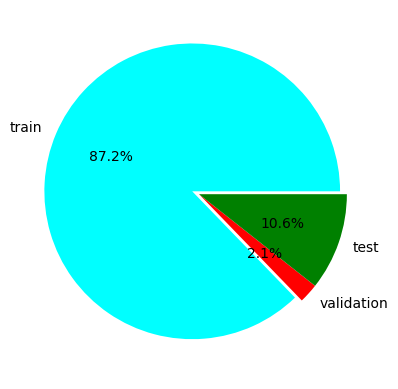

In [ ]:
plt.pie([len(train_gen), len(val_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.savefig('Readme_Images/dataset_pie.png')
plt.show()

**Class Index in Each of the Three Batches(Train, Test, Validation)**

In [ ]:
print(train_gen.class_indices)
print(val_gen.class_indices)
print(test_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


## Image Sample Visualization

**i. Training Images**

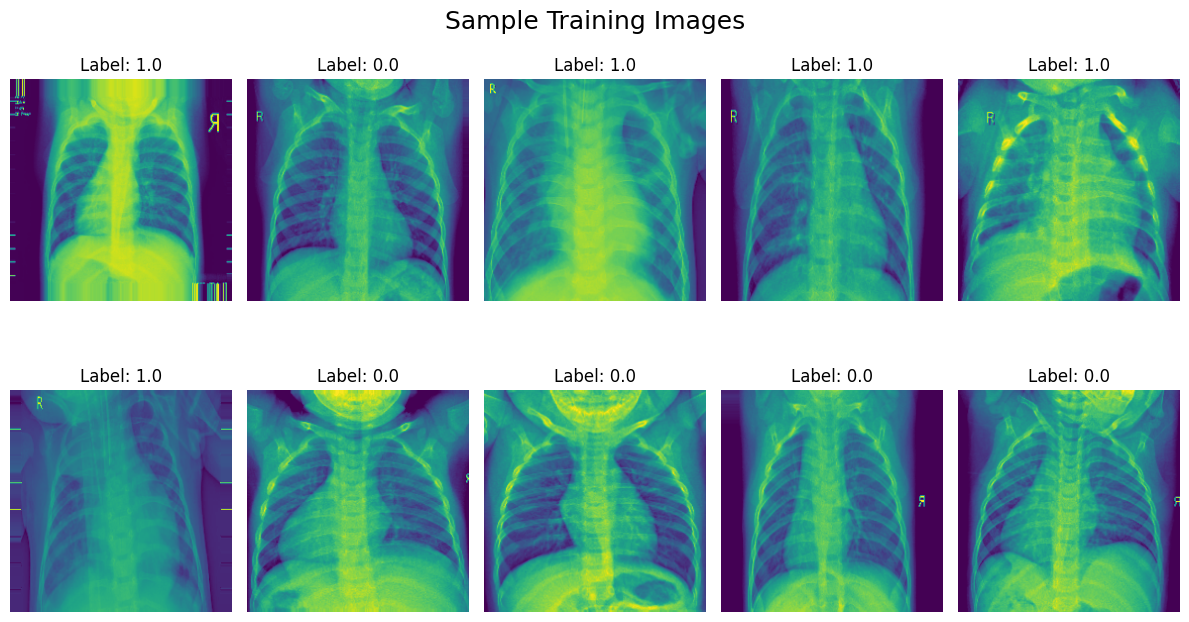

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12, 7))
idx = 0

train_data, train_labels = train_gen[0]

for i in range(2):
    for j in range(5):
        label = train_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(train_data[idx])
        ax[i, j].axis('off')
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize = 18)
plt.savefig("Readme_Images/Sample_train_images.png")
plt.show()

**ii. Testing Images**

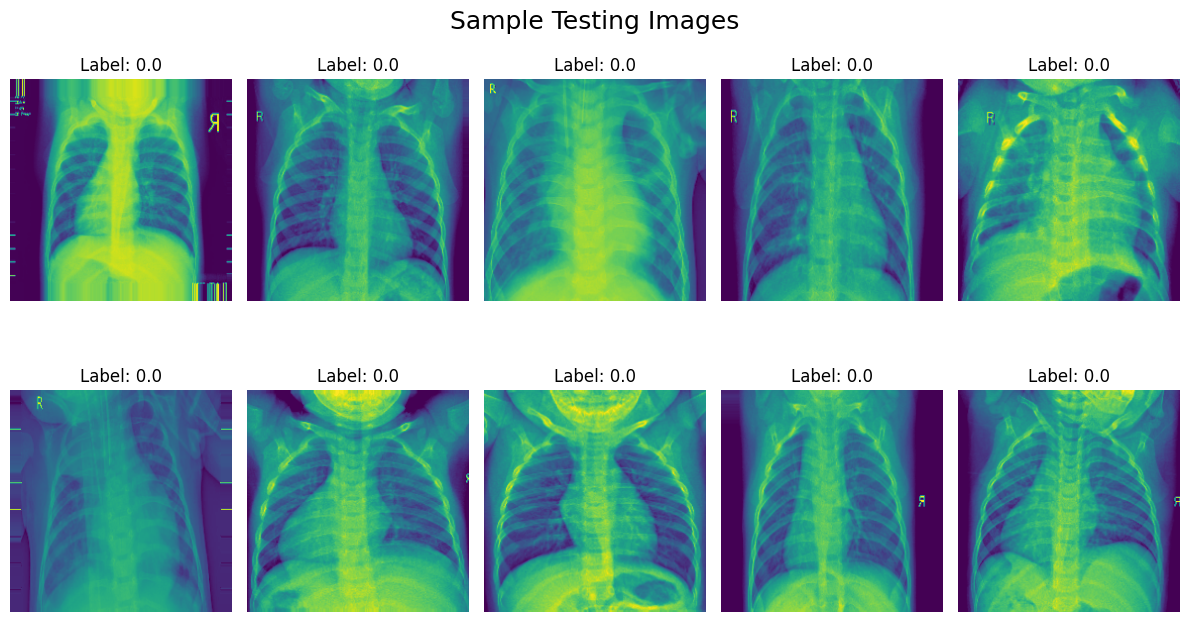

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (12, 7))
idx = 0

test_data, test_labels = test_gen[0]

for i in range(2):
    for j in range(5):
        label = test_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(train_data[idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Testing Images", fontsize = 18)
plt.savefig("Readme_Images/test_image_samples.png")
plt.show()

**iii. Validation Images Sample**

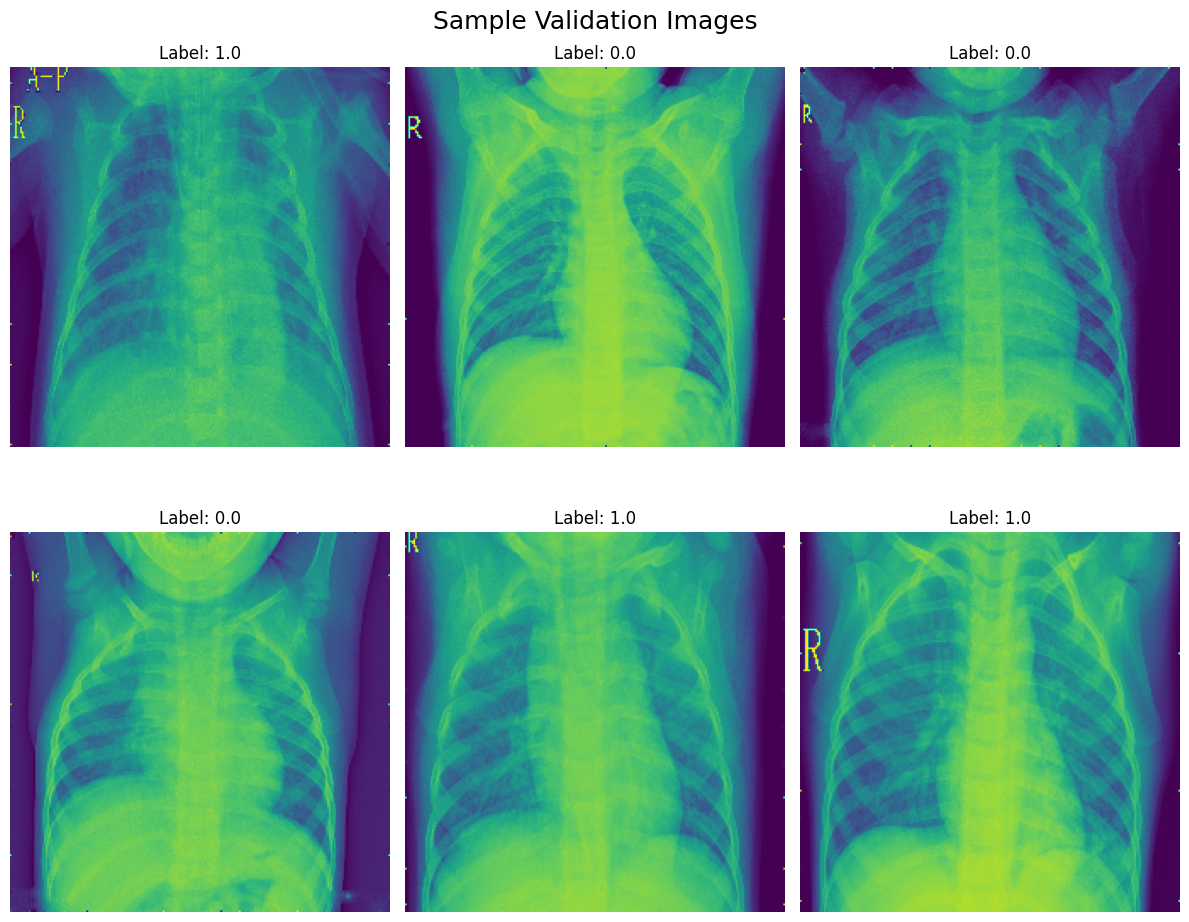

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 10))
idx = 0

val_data, val_labels = val_gen[0]

for i in range(2):
    for j in range(3):
        label = val_labels[idx]
        ax[i, j].set_title(f"Label: {label}")
        ax[i, j].imshow(val_data[idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Validation Images", fontsize = 18)
plt.savefig("Readme_Images/validation_image_samples.png")
plt.show()

## 2. Model Training

1) Implement callback functions to allow the model to train to completion.
2) Create the _Convolutional Neural Network(CNN)_ with InputLayer and layers for hyperparameter tuning.


**i. Callbacks**

- Implement and early stopping function to ensure that the model has more patience in the case that the model accuracy does not improve as the code is run.
- Checkpoints are made to ensure that we save the best performance of our model.

**Aim**

- To optimize the model performance and attain the highest possible accuracy.

In [ ]:
# Introducing an early stopping callback with patience of 5 epochs.
early_stopping = EarlyStopping(verbose = 1,
                            patience = 5,
                            restore_best_weights = True)
# Making a callback to save the Keras Model and model weights at a given frequency.
check_point = ModelCheckpoint(filepath = "weights.keras",
                            monitor = 'val_accuracy',
                            mode = 'max',
                            save_best_only = True)

**ii. Creating the CNN model**

In [ ]:
# Loading the Model
cnn = Sequential()

cnn.add(InputLayer(shape=(hyper_dim, hyper_dim, hyper_channels)))
# This is the first convolution
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', name="L1"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# The second convolution
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', name="L2"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# The third convolution
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', name="L3"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the results to feed into a DNN
cnn.add(Flatten())
cnn.add(Dense(units=512, activation='relu', name="dense1"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

cnn.add(Dense(units=128, activation='relu', name="dense2"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Change the output layer to have two neurons for binary classification
cnn.add(Dense(units=2, activation='softmax'))  # Use softmax for multi-class classification

# Model Compilation
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [AUC(), "accuracy"])

**iii. Model Summary**

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ L1 (Conv2D)                     │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L2 (Conv2D)                     │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ L3 (Conv2D)                     │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │    11,076,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,163,265 (42.58 MB)

 Trainable params: 11,161,985 (42.58 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
start = time.time()
cnn_model = cnn.fit(train_gen,
                    epochs = 11,
                    validation_data = val_gen,
                    callbacks = [early_stopping, check_point],
                    verbose = 2)

end = time.time()
elapsed = end - start
print("Total time elapsed: ", elapsed)

Epoch 1/11
41/41 - 683s - 17s/step - accuracy: 0.8368 - auc: 0.9442 - loss: 0.4134 - val_accuracy: 0.5000 - val_auc: 0.9375 - val_loss: 1.7125
Epoch 2/11
41/41 - 298s - 7s/step - accuracy: 0.9268 - auc: 0.9691 - loss: 0.2503 - val_accuracy: 0.6250 - val_auc: 0.7500 - val_loss: 0.8701
Epoch 3/11
41/41 - 618s - 15s/step - accuracy: 0.9415 - auc: 0.9733 - loss: 0.2096 - val_accuracy: 0.5000 - val_auc: 0.8281 - val_loss: 0.8154
Epoch 4/11
41/41 - 415s - 10s/step - accuracy: 0.9434 - auc: 0.9810 - loss: 0.1863 - val_accuracy: 0.5000 - val_auc: 0.8281 - val_loss: 1.0941
Epoch 5/11
41/41 - 596s - 15s/step - accuracy: 0.9538 - auc: 0.9836 - loss: 0.1578 - val_accuracy: 0.5000 - val_auc: 0.8594 - val_loss: 1.3804
Epoch 6/11
41/41 - 470s - 11s/step - accuracy: 0.9505 - auc: 0.9850 - loss: 0.1561 - val_accuracy: 0.5000 - val_auc: 0.8047 - val_loss: 2.1580
Epoch 7/11
41/41 - 450s - 11s/step - accuracy: 0.9496 - auc: 0.9834 - loss: 0.1589 - val_accuracy: 0.6250 - val_auc: 0.9609 - val_loss: 0.7005


**iv. Showing Metrics and Charts of the Model**

- **Metrics**: Accuracy, Precision, Recall, Specificity and F! Score.
- **Charts**:
  - Train Vs. Validation Loss
  - Training Vs. Validation AUC
  - Confusion Matrix

In [ ]:
def create_chart(cnn, cnn_model):
    '''function plots loss, accuracy plots, AUC curves and confusion matrix

    Args:
        cnn (Keras.Models.Sequential()): the neural network used
        cnn_model (Keras.Models.Sequential().compile()): the convolutional neural network layers made and compiled.
    Returns:
        Nothing
    '''
    # Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    # Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = test_gen.classes
    Y_pred = cnn.predict(test_gen, steps = len(test_gen))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    # PLOT
    fig = plt.figure(figsize=(13, 10))
    
    # PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label = 'training loss')
    plt.plot(val_loss, label = 'validation loss')
    plt.xlabel("Number of Epochs", size = 14)
    plt.legend()

    # PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2, 2, 2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label = 'training auc')
    plt.plot(val_auc, label = 'validation auc')
    plt.xlabel("Number of Epochs", size = 14)
    plt.legend()
    
    # PLOT 3: CONFUSION MATRIX
    plt.subplot(2, 2, 3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set_theme(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    plt.savefig('Readme_Images/cm.png', transparent=True) 
    
    # PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    plt.savefig('Readme_Images/roc.png', bbox_inches='tight', pad_inches=1)
    
    # END PLOTS
    plt.tight_layout()
    
    # Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step
[Summary Statistics]
Accuracy = 85.42% | Precision = 94.63% | Recall = 81.28% | Specificity = 92.31% | F1 Score = 87.45%


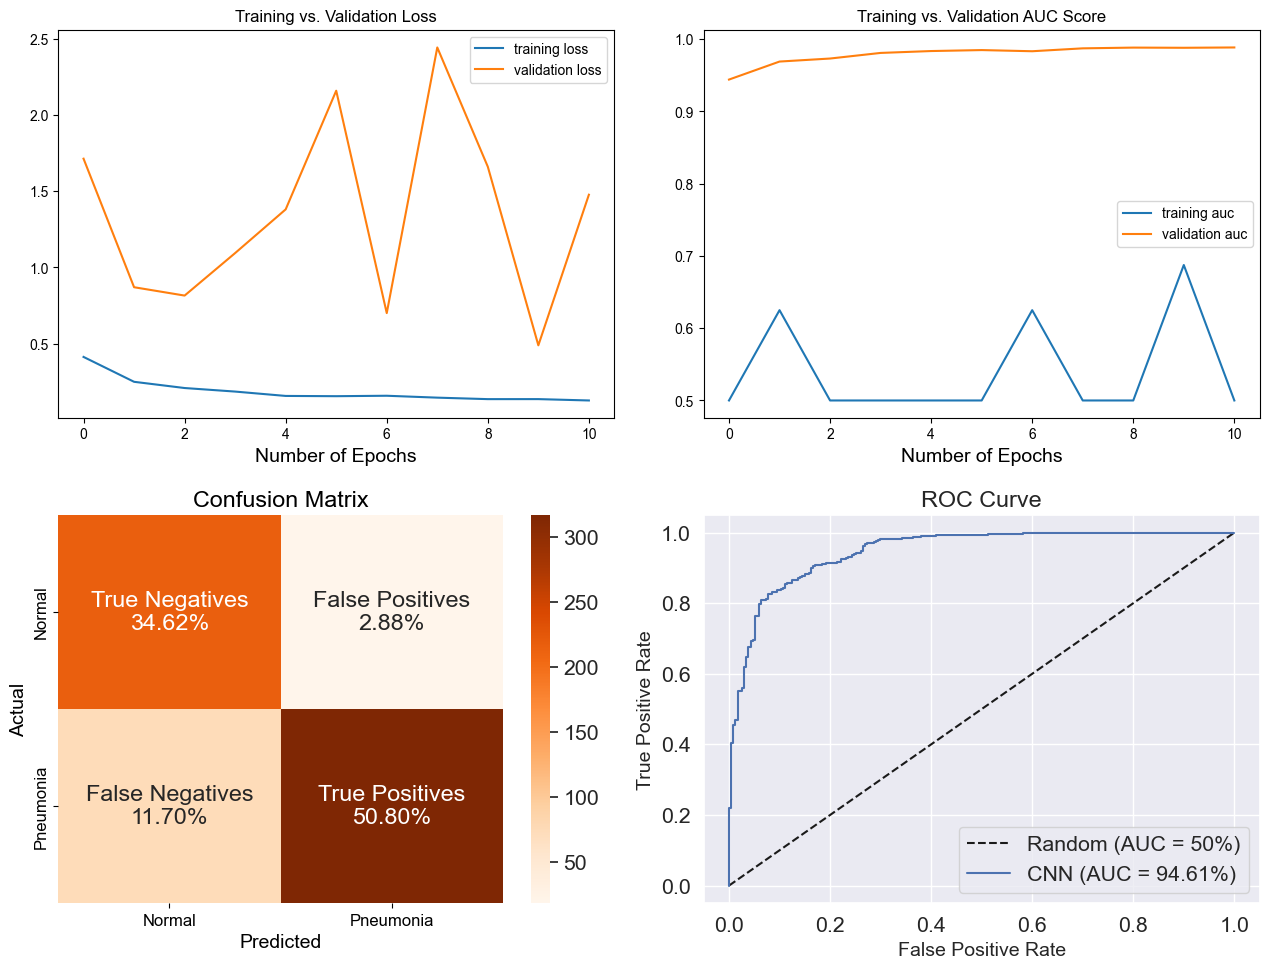

In [ ]:
create_chart(cnn, cnn_model)

## 3. Model Evaluation

**i. Average Accuracy**

In [ ]:
evaluate_result = cnn.evaluate(test_gen)
avg_acc = sum(evaluate_result) / len(evaluate_result)
print("Average Accuracy: ", avg_acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8805 - auc: 0.7867 - loss: 0.3041
Average Accuracy:  0.723146935304006


**ii. Accuracy Plot**

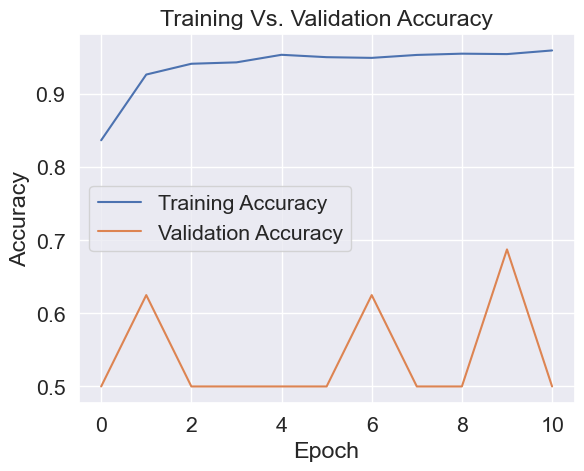

In [ ]:
plt.plot(cnn_model.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Vs. Validation Accuracy')
plt.legend()
plt.savefig("Readme_Images/train_vs_val_acc.png")
plt.show()

In [ ]:
print(cnn_model.history['accuracy'])

[0.8368481397628784, 0.9267638325691223, 0.9415260553359985, 0.943443238735199, 0.9537960290908813, 0.9505367875099182, 0.9495782256126404, 0.9536042809486389, 0.9553297758102417, 0.9547545909881592, 0.9597392678260803]


**iii. Loss**

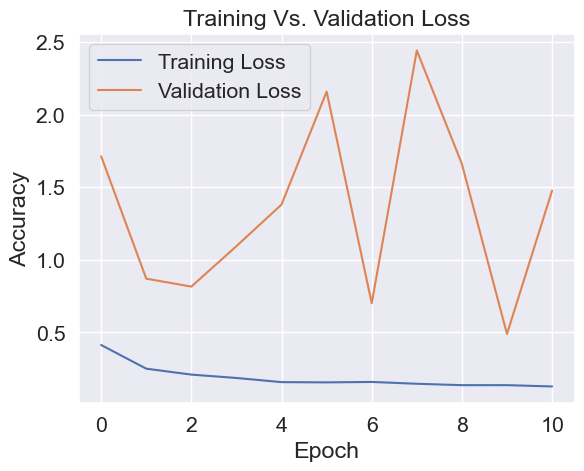

In [ ]:
plt.plot(cnn_model.history['loss'], label = 'Training Loss')
plt.plot(cnn_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Vs. Validation Loss')
plt.legend()
plt.savefig("Readme_Images/train_vs_val_loss.png")
plt.show()

In [ ]:
print(cnn_model.history['loss'])

[0.41335123777389526, 0.2503272593021393, 0.20957808196544647, 0.18630331754684448, 0.1577608585357666, 0.15606987476348877, 0.15893088281154633, 0.14652018249034882, 0.13677965104579926, 0.13690701127052307, 0.12798713147640228]


## 4. Creating Deployment Model Version v1.0


- It is important we save our model in a format that can be utilized in testing for Pneumonia positiveness or negativeness.

In [ ]:
cnn.save('webapp/model/pneumonia_x_rays_v1_0.keras')